#Package Setup

## Installations

In [10]:
# pip install umap-learn
# pip install sentence-transformers
# pip install pyvis

## Imports

In [11]:
import csv
import umap
from scipy import spatial
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from collections import defaultdict
import pyvis
from pyvis.network import Network
import numpy as np
import seaborn as sns
import branca.colormap as cm
import branca
import pandas as pd
import re
from textwrap import wrap
import json
import os

project_path = os.getcwd()

# Visualization Creation Process

## Create Embeddings from Raw Data

In [12]:
# Read attendees and their responses from a CSV file, replace attendees.csv with own link or file name
attendees_map = {}
with open(os.path.join(project_path, 'MCDA5511-classmates - 2025 - modified.csv'), newline='') as csvfile:
    attendees = csv.reader(csvfile, delimiter=',', quotechar='"')
    next(attendees)  # Skip the header row
    for row in attendees:
        name, paragraph = row
        attendees_map[paragraph] = name

# Generate sentence embeddings
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
paragraphs = list(attendees_map.keys())
embeddings = model.encode(paragraphs)

# Create a dictionary to store embeddings for each person
person_embeddings = {attendees_map[paragraph]: embedding for paragraph, embedding in zip(paragraphs, embeddings)}

csv_file = "person_embeddings_modified.csv"

# Open the CSV file for writing
with open(csv_file, 'w') as file:
    writer = csv.writer(file)
    writer.writerow(["Name", "Embedding"])
    for name, embedding in person_embeddings.items():
        writer.writerow([name] + list(embedding))
        
print(f"Data saved to {csv_file}")

Data saved to person_embeddings_modified.csv


## Reducing dimensionality of embedding data, scaling to coordinate domain/range


In [13]:
# Reducing dimensionality of embedding data, scaling to coordinate domain/range
reducer = umap.UMAP(random_state=42)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(list(person_embeddings.values()))
reduced_data = reducer.fit_transform(scaled_data)


c:\Users\ethan\Documents\Winter 2025\CSCI 4551\Assignments\A1_MCDA_5511\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ethan\Documents\Winter 2025\CSCI 4551\Assignments\A1_MCDA_5511\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## Create Visualization Image

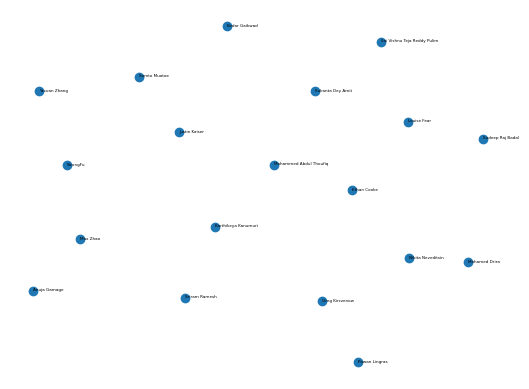

In [14]:
# Creating lists of coordinates with accompanying labels
x = [row[0] for row in reduced_data]
y = [row[1] for row in reduced_data]
label = list(person_embeddings.keys())

# Plotting and annotating data points
plt.scatter(x,y)
for i, name in enumerate(label):
    plt.annotate(name, (x[i], y[i]), fontsize="3")

# Clean-up and Export
plt.axis('off')
plt.savefig(os.path.join(project_path,'a_visualization.png'), dpi=800)

## Find the  top N matches to a node

In [15]:
# Providing top matches
top_matches = {}
all_personal_pairs = defaultdict(list)
for person in attendees_map.values():
    for person1 in attendees_map.values():
        all_personal_pairs[person].append([spatial.distance.cosine(person_embeddings[person1], person_embeddings[person]), person1])

n = 5
# Collect the top n most similarity nodes
data_day_list = []
for person in attendees_map.values():
    top_matches[person] = sorted(all_personal_pairs[person], key=lambda x: x[0])[1:n+1] # drop yourself, take top 5
    a = sorted(all_personal_pairs[person], key=lambda x: x[0])[1:n+1]
    mini_df = pd.DataFrame(a, columns=['Weight', 'Target'])
    mini_df['Source'] = person
    data_day_list.append(mini_df)

top_matches_serializable = {
    person: [
        [float(pair[0]), pair[1]] for pair in matches
    ]
    for person, matches in top_matches.items()
}

with open(os.path.join(project_path,'b_top5_matches.json'), 'w') as json_file:
    json.dump(top_matches_serializable, json_file)

# Output this information as a csv
df = pd.concat(data_day_list)
df.to_csv(os.path.join(project_path,'b_top5_matches.json'))


## Add Colour/Paragraph Information to Dataframe

In [16]:
# Get the colour pallette
colour = sns.color_palette("pastel",len(x)).as_hex()

# Add colour pallette to the df
df1 = pd.DataFrame([label,colour])
df1 = df1.T
df1.rename(columns={0: 'Source', 1: 'Colour'},inplace=True)
df = df.set_index('Source').join(df1.set_index('Source'))
df['Source'] = df.index
df = df.reset_index(drop=True)

# Add colour pallette for both the df Target and Source:
df1.rename(columns={'Source': 'Target'},inplace=True)
df = df.set_index('Target').join(df1.set_index('Target'),lsuffix='_Source', rsuffix='_Target')
df['Target'] = df.index
df = df.reset_index(drop=True)
print(df)

# Add paragraphs to the df
df2 = pd.DataFrame([label,paragraphs])
df2 = df2.T
df2.rename(columns={0: 'Source', 1: 'Paragraphs'},inplace=True)
df = df.set_index('Source').join(df2.set_index('Source'))
df['Source'] = df.index
df = df.reset_index(drop=True)
print(df)

# Create a cleaned Dataframe of just the Source and and Paragraph information
df_new = df[["Source","Paragraphs"]]
df_new = df_new.drop_duplicates()
df_new.set_index('Source', inplace=True)

      Weight Colour_Source          Source Colour_Target  \
0   0.275552       #a1c9f4  Greg Kirczenow       #8de5a1   
1   0.299058       #a1c9f4  Greg Kirczenow       #ffb482   
2   0.302179       #a1c9f4  Greg Kirczenow       #debb9b   
3   0.363524       #a1c9f4  Greg Kirczenow       #d0bbff   
4   0.407976       #a1c9f4  Greg Kirczenow       #debb9b   
..       ...           ...             ...           ...   
90  0.385660       #fffea3   Sriram Ramesh       #debb9b   
91  0.407616       #fffea3   Sriram Ramesh       #8de5a1   
92  0.417010       #fffea3   Sriram Ramesh       #ff9f9b   
93  0.428615       #fffea3   Sriram Ramesh       #b9f2f0   
94  0.433370       #fffea3   Sriram Ramesh       #ffb482   

                         Target  
0                 Pawan Lingras  
1             Nikita Neveditsin  
2                   Ethan Cooke  
3                   Louise Fear  
4              Sukanta Dey Amit  
..                          ...  
90                  Ethan Cooke  
91     

## Build Interative Network Visualization (Simple)

In [17]:
# Intitalize bucket size and colour palettes
buckets = [100] * len(x)
colour = sns.color_palette("pastel",len(x)).as_hex()

# Initialize network
g = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")

# Add unconnected nodes to the network
g.add_nodes(list(range(1,len(x)+1)), value=buckets,
                         title=paragraphs,
                         x=np.array(x).astype(np.float64),
                         y=np.array(y).astype(np.float64),
                         label=label,
                         color=colour)

# Output the visualization
g.toggle_physics(True)
g.show(os.path.join(project_path,'c_simple_viz.html'), notebook=False)

c:\Users\ethan\Documents\Winter 2025\CSCI 4551\Assignments\A1_MCDA_5511\c_simple_viz.html


## Build Interative Network Visualization (Complex)


In [18]:
# Initialize network
got_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white",select_menu=True,cdn_resources='remote')

# Create a dictionary of Important information
sources = df['Source']
targets = df['Target']
weights = df['Weight']
color_targets = df['Colour_Target']
color_sources = df['Colour_Source']

edge_data = zip(sources, targets, weights,color_targets,color_sources)

# Add nodes and edges to the network
for e in edge_data:
                src = e[0]
                dst = e[1]
                w = e[2]
                c_t= e[3]
                c_s= e[4]
                got_net.add_node(src, src, title=src,color=c_s)
                got_net.add_node(dst, dst, title=dst)
                got_net.add_edge(src, dst, value=w)#,color = "#c79910") # if you  want a solide colour for edges

# Add paragraphs to the popup
for i,node in enumerate(got_net.nodes):
               content =df_new.loc[node.get("title"),"Paragraphs"]
               node["title"] += ": "+ "\n \n" +'\n'.join(wrap(content, width=50))

## Output the visualization
got_net.show(os.path.join(project_path,'c_complex_viz.html'), notebook=False)

c:\Users\ethan\Documents\Winter 2025\CSCI 4551\Assignments\A1_MCDA_5511\c_complex_viz.html
